In [1]:
import torch

print(torch.__version__)

if torch.cuda.is_available():
    print("GPU is available.")
else:
    print("GPU is not available.")


2.1.0+cu118
GPU is available.


In [2]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST # Training dataset
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for testing purposes, please do not change!

def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in a uniform grid.
    '''
    image_unflat = image_tensor.view(-1, *size).detach()#.cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

## Generator


In [3]:
def get_generator_block(input_dim, output_dim):
    '''
    Function for returning a block of the generator's neural network
    given input and output dimensions.
    Parameters:
        input_dim: the dimension of the input vector, a scalar
        output_dim: the dimension of the output vector, a scalar
    Returns:
        a generator neural network layer, with a linear transformation
          followed by a batch normalization and then a relu activation
    '''
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.BatchNorm1d(output_dim),
        nn.ReLU(inplace=True),
    )

In [4]:
# Verify the generator block function
def test_gen_block(in_features, out_features, num_test=1000):
    block = get_generator_block(in_features, out_features)

    # Check the three parts
    assert len(block) == 3
    assert type(block[0]) == nn.Linear
    assert type(block[1]) == nn.BatchNorm1d
    assert type(block[2]) == nn.ReLU

    # Check the output shape
    test_input = torch.randn(num_test, in_features)
    test_output = block(test_input)
    assert tuple(test_output.shape) == (num_test, out_features)
    assert test_output.std() > 0.55
    assert test_output.std() < 0.65
    print("test input",test_input," test output",test_output)


test_gen_block(25, 12)
test_gen_block(15, 28)
print("Success!")

test input tensor([[-1.4453e+00, -8.0777e-01,  1.1975e+00,  ...,  4.8999e-01,
          2.9082e-01, -1.1311e+00],
        [-9.3218e-04, -1.6269e-01, -2.4772e-01,  ..., -1.3707e+00,
          3.2207e-01, -1.0157e-01],
        [ 2.0599e-01,  1.2168e+00,  1.2359e+00,  ..., -1.8972e+00,
         -2.2274e-03, -1.9721e+00],
        ...,
        [ 3.6248e-02, -1.5181e-01,  2.4674e+00,  ...,  1.3289e+00,
         -1.7502e-01, -3.7241e-02],
        [ 6.4695e-01,  1.1354e+00, -7.6104e-01,  ..., -4.7605e-01,
         -7.8196e-01, -4.1704e-01],
        [-5.0210e-01, -2.8807e-01, -7.4439e-01,  ..., -8.4391e-01,
          9.7432e-01,  1.3546e-01]])  test output tensor([[0.0000, 0.0000, 0.6656,  ..., 0.5575, 0.4973, 1.2247],
        [0.0000, 0.3465, 0.5196,  ..., 0.0000, 0.4976, 0.5701],
        [0.0000, 0.0000, 1.1795,  ..., 0.2570, 1.4623, 0.4118],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0359, 0.0000],
        [1.6405, 0.0000, 0.1708,  ..., 0.2684, 0.0000, 0.6309],
        [1.

In [5]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
          (MNIST images are 28 x 28 = 784 so that is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_dim=784, hidden_dim=128):
        super(Generator, self).__init__()
        # Build the neural network
        self.gen = nn.Sequential(
            get_generator_block(z_dim, hidden_dim),
            get_generator_block(hidden_dim, hidden_dim * 2),
            get_generator_block(hidden_dim * 2, hidden_dim * 4),
            get_generator_block(hidden_dim * 4, hidden_dim * 8),

            nn.Linear(hidden_dim * 8, im_dim),
            nn.Sigmoid()
        )
    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor,
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        return self.gen(noise)

    def get_gen(self):
        '''
        Returns:
            the sequential model
        '''
        return self.gen

test_output torch.Size([10000, 784])
test_output torch.Size([10000, 10])
test_output torch.Size([10000, 8])
Success!


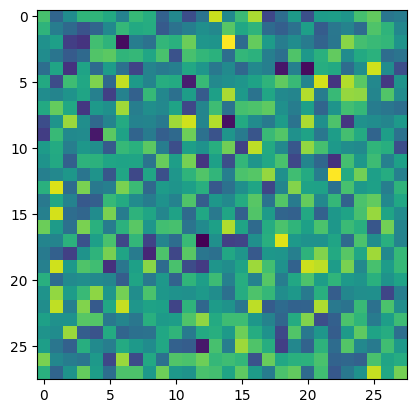

In [6]:
# Verify the generator class
import matplotlib.pyplot as plt
import numpy as np
def test_generator(z_dim, im_dim, hidden_dim, num_test=10000):
    gen = Generator(z_dim, im_dim, hidden_dim).get_gen()

    # Check there are six modules in the sequential part
    assert len(gen) == 6
    test_input = torch.randn(num_test, z_dim)
    test_output = gen(test_input)

    # Check that the output shape is correct
    assert tuple(test_output.shape) == (num_test, im_dim)
    assert test_output.max() < 1, "Make sure to use a sigmoid"
    assert test_output.min() > 0, "Make sure to use a sigmoid"
    assert test_output.std() > 0.05, "Don't use batchnorm here"
    assert test_output.std() < 0.15, "Don't use batchnorm here"
    print("test_output",test_output.shape)
    if(z_dim==10):
      plt.imshow(test_output[0].detach().numpy().reshape(28,28))


test_generator(10,784,8)
test_generator(5, 10, 20)
test_generator(20, 8, 24)
print("Success!")

## Noise


In [7]:
def get_noise(n_samples, z_dim, device='cuda'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim),
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    # NOTE: To use this on GPU with device='cuda', make sure to pass the device
    # argument to the function you use to generate the noise.
    return torch.randn(n_samples, z_dim, device=device)

In [8]:
# Verify the noise vector function
def test_get_noise(n_samples, z_dim, device='cpu'):
    noise = get_noise(n_samples, z_dim, device)

    # Make sure a normal distribution was used
    assert tuple(noise.shape) == (n_samples, z_dim)
    assert torch.abs(noise.std() - torch.tensor(1.0)) < 0.01
    assert str(noise.device).startswith(device)

test_get_noise(1000, 100, 'cpu')
if torch.cuda.is_available():
    test_get_noise(1000, 32, 'cuda')
    print("Success on gpu!")
else:
    print("Success!")

Success on gpu!


## Discriminator


In [9]:
def get_discriminator_block(input_dim, output_dim):
    '''
    Discriminator Block
    Function for returning a neural network of the discriminator given input and output dimensions.
    Parameters:
        input_dim: the dimension of the input vector, a scalar
        output_dim: the dimension of the output vector, a scalar
    Returns:
        a discriminator neural network layer, with a linear transformation
          followed by an nn.LeakyReLU activation with negative slope of 0.2
          (https://pytorch.org/docs/master/generated/torch.nn.LeakyReLU.html)
    '''
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.LeakyReLU(0.2, inplace=True)
    )

In [10]:
# Verify the discriminator block function
def test_disc_block(in_features, out_features, num_test=10000):
    block = get_discriminator_block(in_features, out_features)

    # Check there are two parts
    assert len(block) == 2
    test_input = torch.randn(num_test, in_features)
    test_output = block(test_input)

    # Check that the shape is right
    assert tuple(test_output.shape) == (num_test, out_features)

    # Check that the LeakyReLU slope is about 0.2
    assert -test_output.min() / test_output.max() > 0.1
    assert -test_output.min() / test_output.max() < 0.3
    assert test_output.std() > 0.3
    assert test_output.std() < 0.5
    print(test_output.shape)

test_disc_block(25, 12)
test_disc_block(15, 28)
print("Success!")

torch.Size([10000, 12])
torch.Size([10000, 28])
Success!


Now you can use these blocks to make a discriminator! The discriminator class holds 2 values:

*   The image dimension
*   The hidden dimension

The discriminator will build a neural network with 4 layers. It will start with the image tensor and transform it until it returns a single number (1-dimension tensor) output. This output classifies whether an image is fake or real. Note that you do not need a sigmoid after the output layer since it is included in the loss function. Finally, to use your discrimator's neural network you are given a forward pass function that takes in an image tensor to be classified.


In [11]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
            (MNIST images are 28x28 = 784 so that is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_dim=784, hidden_dim=128):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            get_discriminator_block(im_dim, hidden_dim * 4),
            get_discriminator_block(hidden_dim * 4, hidden_dim * 2),
            get_discriminator_block(hidden_dim * 2, hidden_dim),
            # Hint: You want to transform the final output into a single value,
            #       so add one more linear map.
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor,
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_dim)
        '''
        return self.disc(image)

    # Needed for grading
    def get_disc(self):
        '''
        Returns:
            the sequential model
        '''
        return self.disc

In [12]:
# Verify the discriminator class
def test_discriminator(z_dim, hidden_dim, num_test=100):

    disc = Discriminator(z_dim, hidden_dim).get_disc()

    # Check there are three parts
    assert len(disc) == 4

    # Check the linear layer is correct
    test_input = torch.randn(num_test, z_dim)
    test_output = disc(test_input)
    assert tuple(test_output.shape) == (num_test, 1)

    # Make sure there's no sigmoid
    assert test_input.max() > 1
    assert test_input.min() < -1
    print(test_input)

test_discriminator(5, 10)
test_discriminator(20, 8)
print("Success!")

tensor([[ 2.0252e+00, -1.3020e+00,  5.5647e-01,  9.6981e-01, -1.3461e+00],
        [-4.7020e-01,  1.5152e+00, -1.6342e+00, -5.7453e-01,  1.7989e+00],
        [ 1.0351e-01, -1.7379e+00,  1.6047e+00,  5.7669e-01, -1.2884e+00],
        [ 6.5724e-01, -1.2296e+00,  1.5062e+00,  7.4585e-01,  8.1864e-02],
        [-9.0345e-01,  8.6043e-03,  1.5823e+00, -4.4295e-01, -2.0179e-02],
        [-1.7935e-01, -9.7050e-01, -9.3068e-01, -1.2004e+00,  9.8140e-01],
        [-9.3889e-03,  1.0635e+00,  3.8568e-01,  2.3180e-01, -5.3841e-01],
        [ 7.7235e-01,  1.4663e+00,  1.2415e+00,  1.0672e-01, -1.2738e-01],
        [ 1.6273e-01, -7.6134e-01, -9.3133e-01, -1.1048e+00,  3.4008e-01],
        [-1.1889e+00,  7.1011e-02, -1.1789e+00,  9.3241e-01, -1.9924e+00],
        [-6.9031e-01, -1.5896e+00, -6.6204e-01, -1.1265e+00,  2.0616e-01],
        [-3.6603e-01,  1.1415e+00, -2.8924e-01, -5.8836e-01, -1.9494e-02],
        [-6.9338e-01,  1.5204e+00,  6.0472e-01, -7.2212e-01,  1.0158e+00],
        [-8.7739e-02,  1.

## Turning hyperparameters to get a great performance (with lower printed loss).



In [13]:
# Set your parameters
criterion = nn.BCEWithLogitsLoss()
n_epochs = 150
z_dim = 70
display_step = 500
batch_size = 128
lr = 0.0001

In [14]:
# Load MNIST dataset as tensors
dataloader = DataLoader(
    MNIST('.', download=True, transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True)

device = 'cuda' # or 'cpu'

100%|██████████| 9912422/9912422 [00:00<00:00, 99105884.14it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

100%|██████████| 28881/28881 [00:00<00:00, 70922537.37it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 23432182.14it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 19379988.57it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [15]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

In [16]:
def get_disc_loss(gen, disc, criterion, real, num_images, z_dim, device):
    '''
    Return the loss of the discriminator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare
               the discriminator's predictions to the ground truth reality of the images
               (e.g. fake = 0, real = 1)
        real: a batch of real images
        num_images: the number of images the generator should produce,
                which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        disc_loss: a torch scalar loss value for the current batch
    '''


    noise = get_noise(num_images, z_dim,device='cuda')
    fake_image_gen =gen(noise)
    fake_image_pred = disc(fake_image_gen)
    fake_image_loss = criterion(fake_image_pred,torch.zeros_like(fake_image_pred))
    real_image_pred = disc(real)
    real_image_loss = criterion(real_image_pred, torch.ones_like(real_image_pred))
    disc_loss = (fake_image_loss + real_image_loss) / 2
    #### END CODE HERE ####
    return disc_loss

In [17]:
def get_gen_loss(gen, disc, criterion, num_images, z_dim, device):
    '''
    Return the loss of the generator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare
               the discriminator's predictions to the ground truth reality of the images
               (e.g. fake = 0, real = 1)
        num_images: the number of images the generator should produce,
                which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        gen_loss: a torch scalar loss value for the current batch
    '''

    noise =get_noise(num_images, z_dim,device='cuda')
    fake_image_gen = gen(noise)
    fake_image_pred =  disc(fake_image_gen)
    gen_loss = criterion(fake_image_pred, torch.ones_like(fake_image_pred))
    #### END CODE HERE ####
    return gen_loss

In [47]:
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
gen_loss = False
g_arr_loss=[]
d_arr_loss=[]
error = False
for epoch in range(n_epochs):

    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)

        # Flatten the batch of real images from the dataset
        real = real.view(cur_batch_size, -1).to(device)

        ### Update discriminator ###
        # Zero out the gradients before backpropagation
        disc_opt.zero_grad()

        # Calculate discriminator loss
        disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size, z_dim, device)

        # Update gradients
        disc_loss.backward(retain_graph=True)

        # Update optimizer
        disc_opt.step()

        ### Update generator ###
        #     Hint: This code will look a lot like the discriminator updates!
        #     These are the steps you will need to complete:
        #       1) Zero out the gradients.
        #       2) Calculate the generator loss, assigning it to gen_loss.
        #       3) Backprop through the generator: update the gradients and optimizer.
        #### START CODE HERE ####
        gen_opt.zero_grad()
        # TODO #
        gen_loss = get_gen_loss(gen, disc, criterion, cur_batch_size, z_dim, device)
        # TODO #
        # TODO #
        gen_loss.backward(retain_graph=True)
        gen_opt.step()
        #### END CODE HERE ####

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Epoch {epoch}, step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            g_arr_loss.append(mean_generator_loss)
            d_arr_loss.append(mean_discriminator_loss)
            # show_tensor_images(fake)
            # show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1, step 500: Generator loss: 2.890874208927154, discriminator loss: 0.19304128545522684


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2, step 1000: Generator loss: 2.7561646881103514, discriminator loss: 0.21660061071813105


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3, step 1500: Generator loss: 2.706420361518859, discriminator loss: 0.2108102188557387


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4, step 2000: Generator loss: 2.687646040439609, discriminator loss: 0.21626404556632012


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5, step 2500: Generator loss: 2.5100008525848385, discriminator loss: 0.23820728886127493


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 6, step 3000: Generator loss: 2.4690471565723437, discriminator loss: 0.24620516204833992


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 7, step 3500: Generator loss: 2.3649974474906896, discriminator loss: 0.26118871015310297


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 8, step 4000: Generator loss: 2.510409991502762, discriminator loss: 0.2372402700483799


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 9, step 4500: Generator loss: 2.627324650764467, discriminator loss: 0.232075953245163


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 10, step 5000: Generator loss: 2.458689588785172, discriminator loss: 0.24527158135175697


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 11, step 5500: Generator loss: 2.288396261692049, discriminator loss: 0.27036557808518413


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 12, step 6000: Generator loss: 2.188534193515777, discriminator loss: 0.28594342243671395


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 13, step 6500: Generator loss: 2.2338851730823515, discriminator loss: 0.27914647701382644


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 14, step 7000: Generator loss: 2.281792893648148, discriminator loss: 0.26864787393808365


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 15, step 7500: Generator loss: 2.1937687199115747, discriminator loss: 0.2858115720748903


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 17, step 8000: Generator loss: 2.1042314469814296, discriminator loss: 0.29891570124030115


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 18, step 8500: Generator loss: 2.06298307657242, discriminator loss: 0.30772793692350403


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 19, step 9000: Generator loss: 2.0711039478778845, discriminator loss: 0.30833298245072355


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 20, step 9500: Generator loss: 2.016061951398849, discriminator loss: 0.3242281885445115


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 21, step 10000: Generator loss: 2.041058687686919, discriminator loss: 0.329767996519804


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 22, step 10500: Generator loss: 1.9011111083030694, discriminator loss: 0.340321921646595


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 23, step 11000: Generator loss: 1.924491414308547, discriminator loss: 0.3426659201085569


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 24, step 11500: Generator loss: 1.9874689717292788, discriminator loss: 0.32730618500709546


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 25, step 12000: Generator loss: 1.9562439684867852, discriminator loss: 0.33397659999132157


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 26, step 12500: Generator loss: 1.9112840204238883, discriminator loss: 0.33801303774118435


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 27, step 13000: Generator loss: 1.9228843433856955, discriminator loss: 0.34834009104967134


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 28, step 13500: Generator loss: 1.8441850078105921, discriminator loss: 0.34528404745459546


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 29, step 14000: Generator loss: 1.865469826698302, discriminator loss: 0.348854161560535


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 30, step 14500: Generator loss: 1.8411897752284985, discriminator loss: 0.34531288552284245


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 31, step 15000: Generator loss: 1.8905194444656368, discriminator loss: 0.34948663926124585


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 33, step 15500: Generator loss: 1.8643304209709168, discriminator loss: 0.34357289481163034


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 34, step 16000: Generator loss: 1.832802772760391, discriminator loss: 0.3518815423548222


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 35, step 16500: Generator loss: 1.8785616245269772, discriminator loss: 0.34972325843572616


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 36, step 17000: Generator loss: 1.8378595709800722, discriminator loss: 0.3495497379899026


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 37, step 17500: Generator loss: 1.8589713201522837, discriminator loss: 0.34806338086724314


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 38, step 18000: Generator loss: 1.7462862071990963, discriminator loss: 0.36237165844440467


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 39, step 18500: Generator loss: 1.8153738400936121, discriminator loss: 0.3501998523175714


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 40, step 19000: Generator loss: 1.7854078464508059, discriminator loss: 0.3637163744568827


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 41, step 19500: Generator loss: 1.7745549712181106, discriminator loss: 0.3610303755402564


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 42, step 20000: Generator loss: 1.739121306180954, discriminator loss: 0.3693689179420469


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 43, step 20500: Generator loss: 1.8589241657257083, discriminator loss: 0.34872601217031474


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 44, step 21000: Generator loss: 1.850142244815827, discriminator loss: 0.3535021748840805


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 45, step 21500: Generator loss: 1.7631562020778662, discriminator loss: 0.3564795428514479


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 46, step 22000: Generator loss: 1.7844750423431388, discriminator loss: 0.36418796104192774


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 47, step 22500: Generator loss: 1.7590662422180163, discriminator loss: 0.3617364189624782


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 49, step 23000: Generator loss: 1.7328523664474496, discriminator loss: 0.36835124284029025


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 50, step 23500: Generator loss: 1.7199309833049767, discriminator loss: 0.3707796124219891


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 51, step 24000: Generator loss: 1.7263189485073085, discriminator loss: 0.37525804793834705


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 52, step 24500: Generator loss: 1.700334138393402, discriminator loss: 0.37916172933578524


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 53, step 25000: Generator loss: 1.66993817448616, discriminator loss: 0.379146543562412


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 54, step 25500: Generator loss: 1.6889265594482414, discriminator loss: 0.38174832832813255


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 55, step 26000: Generator loss: 1.6224311552047743, discriminator loss: 0.3906377129554745


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 56, step 26500: Generator loss: 1.6891690533161172, discriminator loss: 0.37354643011093136


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 57, step 27000: Generator loss: 1.714800804615019, discriminator loss: 0.3734480847716332


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 58, step 27500: Generator loss: 1.6935804359912876, discriminator loss: 0.37440866434574155


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 59, step 28000: Generator loss: 1.6785852396488188, discriminator loss: 0.3828569899201391


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 60, step 28500: Generator loss: 1.7091722285747533, discriminator loss: 0.38012961012125024


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 61, step 29000: Generator loss: 1.7025641300678276, discriminator loss: 0.3808409712910654


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 62, step 29500: Generator loss: 1.6607231535911562, discriminator loss: 0.3866861152648925


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 63, step 30000: Generator loss: 1.6483344476222983, discriminator loss: 0.39061291480064364


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 65, step 30500: Generator loss: 1.6624213392734533, discriminator loss: 0.3834048550724987


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 66, step 31000: Generator loss: 1.674347893476486, discriminator loss: 0.38167694836854865


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 67, step 31500: Generator loss: 1.6566112079620356, discriminator loss: 0.39367953145504


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 68, step 32000: Generator loss: 1.6457646465301534, discriminator loss: 0.38687079399824187


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 69, step 32500: Generator loss: 1.6305946338176744, discriminator loss: 0.39116432374715826


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 70, step 33000: Generator loss: 1.6377935402393335, discriminator loss: 0.3932031179070476


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 71, step 33500: Generator loss: 1.6384879899024953, discriminator loss: 0.38607221096754074


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 72, step 34000: Generator loss: 1.6509217357635504, discriminator loss: 0.3871093555688858


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 73, step 34500: Generator loss: 1.633583727836611, discriminator loss: 0.38981986612081504


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 74, step 35000: Generator loss: 1.6122895894050604, discriminator loss: 0.3963220814466478


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 75, step 35500: Generator loss: 1.5784312660694124, discriminator loss: 0.40378978800773574


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 76, step 36000: Generator loss: 1.5917079160213468, discriminator loss: 0.40225045186281183


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 77, step 36500: Generator loss: 1.6060583105087285, discriminator loss: 0.39334527963399885


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 78, step 37000: Generator loss: 1.602974306344986, discriminator loss: 0.399972660779953


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 79, step 37500: Generator loss: 1.5898656167984007, discriminator loss: 0.40173242503404577


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 81, step 38000: Generator loss: 1.5839342386722564, discriminator loss: 0.40261752539873136


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 82, step 38500: Generator loss: 1.554533172369004, discriminator loss: 0.41154504293203353


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 83, step 39000: Generator loss: 1.5793771622180948, discriminator loss: 0.4009328849315641


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 84, step 39500: Generator loss: 1.6060530400276187, discriminator loss: 0.4026864263415335


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 85, step 40000: Generator loss: 1.5659095802307148, discriminator loss: 0.4052385068535806


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 86, step 40500: Generator loss: 1.5890194230079664, discriminator loss: 0.4005201016664502


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 87, step 41000: Generator loss: 1.5690075151920324, discriminator loss: 0.4124665682315826


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 88, step 41500: Generator loss: 1.5754870455265033, discriminator loss: 0.40496271789073934


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 89, step 42000: Generator loss: 1.5631273303031894, discriminator loss: 0.4024629727602005


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 90, step 42500: Generator loss: 1.5742150378227242, discriminator loss: 0.40225348567962654


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 91, step 43000: Generator loss: 1.5471970221996314, discriminator loss: 0.40985554963350296


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 92, step 43500: Generator loss: 1.588004123210907, discriminator loss: 0.40186622339487066


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 93, step 44000: Generator loss: 1.573910636901857, discriminator loss: 0.40460877984762156


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 94, step 44500: Generator loss: 1.5853170452117917, discriminator loss: 0.4010124352574347


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 95, step 45000: Generator loss: 1.5830757582187656, discriminator loss: 0.3999308634996414


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 97, step 45500: Generator loss: 1.5584025237560273, discriminator loss: 0.40161591172218314


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 98, step 46000: Generator loss: 1.5534849469661716, discriminator loss: 0.4054759760498999


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 99, step 46500: Generator loss: 1.5685470108985902, discriminator loss: 0.4049361716508863


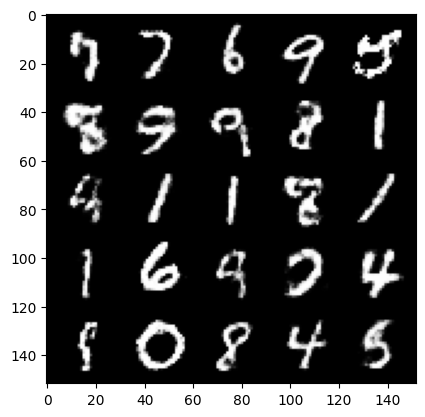

In [49]:
show_tensor_images(fake.to('cpu'))

In [20]:
mean_discriminator_loss

0.14402222046256058

In [21]:
print(mean_generator_loss)

2.3405214591026295


In [22]:
print(mean_discriminator_loss)

0.14402222046256058


In [23]:
print(d_arr_loss)

[0.2066608522683378, 0.07797749568894506, 0.07491468643769625, 0.05343272836320105, 0.05902475792728367, 0.08605271327868111, 0.04471085842233148, 0.07672085023019468, 0.06044069585669784, 0.06768727197963745, 0.05651016927510492, 0.05103955667000258, 0.05430601033894353, 0.06332910227496177, 0.062247140701860215, 0.07137795964814718, 0.05178760816156861, 0.05638849598169326, 0.07353705395758149, 0.05959545263554905, 0.06743380764313044, 0.07530204720608889, 0.0707710408642888, 0.06473811832163483, 0.061761095424182705, 0.07076302662119269, 0.06906353857740763, 0.06890076282806691, 0.07828622103855006, 0.060025003118440584, 0.06556214352883402, 0.07923064208030703, 0.09238538795337085, 0.09384001176804303, 0.08084538964554676, 0.08867223936691879, 0.09104901660606268, 0.0894105959422886, 0.09134940729662777, 0.10092667540907856, 0.10086343850195405, 0.09670130392536522, 0.10071706908568742, 0.12100805897265685, 0.11153152293711913, 0.11956161905825154, 0.12036212944239377, 0.1199019486

In [24]:
print( g_arr_loss)

[5.30275202822685, 5.160087472438812, 5.2134124569892855, 6.646924525260927, 5.845831020355221, 5.306099320411681, 5.7400821456909235, 5.3639566321373, 5.554935003757479, 4.938679921627047, 5.798419816970824, 5.686715950965884, 5.66690143203736, 5.1093106918335, 5.174841254711149, 5.0556553516387925, 5.441443700313572, 5.3266367034912125, 4.922633971214294, 5.097328124523165, 4.819585104465481, 4.757323320388789, 4.770360290527346, 4.995453658580782, 5.072837172985078, 4.729341459274297, 4.8658011837005555, 4.980373275756834, 4.512374598979952, 4.902640635967253, 4.840471796512605, 4.869800175666808, 4.33854002952576, 4.393869412899017, 4.516760442256928, 4.360543548583983, 4.3267823381423955, 4.402356220722201, 4.338554377555847, 4.452909986972814, 4.178497619628908, 4.241719212055208, 4.354785974502566, 3.8998442459106455, 3.9465472497940106, 4.162267340660094, 3.8037144150733906, 3.8773130865097047, 3.8945397853851302, 3.6558129706382734, 3.7531203503608745, 3.6238542814254764, 3.50

In [25]:
# Here I have exprimented varying the noise length, Learning Hyper parameters(Learning Rate) and saved the values

In [26]:
#plots below

In [27]:
# Exp 1
# n_epochs = 100
# z_dim = 64
# display_step = 500
# batch_size = 128
# lr = 0.00001

In [28]:
d_arr1=[0.42536345261335357, 0.27556030958890904, 0.15983346012234684, 0.20046163269877446, 0.1999934642612934, 0.1739183420836925, 0.13720728425681597, 0.10325583539903174, 0.09333731213212013, 0.08806730413436889, 0.0630822076275945, 0.0611658581122756, 0.058782173719257154, 0.06021633996441959, 0.06076219635456808, 0.05905290667712695, 0.05717074360698461, 0.0652892462238669, 0.07126853506267068, 0.05741021647676821, 0.0554811523593962, 0.06414352708309891, 0.06825077464058994, 0.06947870071232323, 0.06923893516510725, 0.0683018336296081, 0.08299177692830566, 0.0889207886904479, 0.08049836967885494, 0.08013046613335605, 0.08491585411876433, 0.08784214270487427, 0.11214287421107286, 0.09555008308589458, 0.10142231402546173, 0.09985843892395489, 0.09985259783267976, 0.1023280410170555, 0.11254962887614961, 0.12095688123255967, 0.1346856769323349, 0.11959909947961564, 0.11880236618965864, 0.143525859616697, 0.15550244882702824, 0.14793462117016312, 0.16077518421411524, 0.15571908402442938, 0.16188302527368065, 0.1635220257937908, 0.16540192360430953, 0.16472077001631236, 0.18052859848737732, 0.19614040525257576, 0.20821064910292642, 0.17377215245366112, 0.18438041545450692, 0.18824111954867875, 0.22005417194962504, 0.21371760362386694, 0.2128750245422126, 0.22917421337962146, 0.211059074357152, 0.20657265429198748, 0.2333782400488854, 0.2275533621311188, 0.23673271358013134, 0.24696472397446645, 0.25568887022137654, 0.2634685215055944, 0.27248302406072616, 0.2651335650384426, 0.24999870938062682, 0.23094084864854808, 0.27772218513488767, 0.28311681807041195, 0.2692487990856171, 0.272444223433733, 0.26941472598910327, 0.29623948991298665, 0.2794868609011175, 0.30689500823616983, 0.295142621397972, 0.3207116615474226, 0.3034957761168479, 0.30722080370783805, 0.3222721628546716, 0.3021593031883237, 0.3182140109539035, 0.32675198531150795, 0.3254875158071519, 0.28915648624300977, 0.29920040768384926]

In [29]:
g_arr1=[1.4086467882394798, 1.7788875272274018, 2.0700368518829335, 1.754993637561798, 1.6958938853740682, 1.9246920647621155, 2.3000161778926818, 2.784662791252134, 3.2006915392875652, 3.205808439254762, 3.677896207809449, 3.831294427871701, 3.7956429042816167, 3.886465352058411, 3.7549327020645142, 3.849665121555327, 4.045794237136841, 4.109909950733185, 3.82925938081741, 4.009289444446565, 4.212552199363706, 4.203539331912992, 4.01890882015228, 3.885488303184509, 3.978148556232453, 4.0439524040222175, 3.802085204124448, 3.8683445510864223, 3.875177190780641, 3.99571481704712, 4.000445547103884, 4.049836396694183, 3.7625831036567687, 3.843658918380739, 3.7354834928512557, 3.7751468095779397, 3.709251369476322, 3.749692480564119, 3.753976170063018, 3.619170379161834, 3.542207943916322, 3.6258996767997718, 3.721144269466397, 3.4702458686828566, 3.2056759872436547, 3.182106298446659, 3.0604203176498386, 3.254020958900454, 3.211363354682919, 3.1200895996093765, 3.161197815418243, 3.1062627849578885, 2.9885105400085457, 2.8351896414756776, 2.744042250156404, 2.9152889037132264, 2.8399577598571786, 2.879530133247374, 2.6613731074333202, 2.631611511230467, 2.6693297829627967, 2.5656271538734425, 2.6388804740905787, 2.7024674496650682, 2.5252608027458185, 2.538349309921264, 2.525056149482731, 2.4262901248931894, 2.4035737264156354, 2.3187571408748644, 2.2930074071884134, 2.271735814809799, 2.303472843885422, 2.5506259121894828, 2.3022022356986978, 2.224092592477796, 2.299275020360948, 2.281533174276351, 2.261897853136063, 2.1601007266044596, 2.188859998941422, 2.057138204336167, 2.0997883279323566, 2.009573573589324, 2.0222894806861893, 2.0294324228763574, 1.9420724947452563, 2.0530706558227543, 1.9890260636806478, 1.9567555902004243, 1.8995056226253526, 2.00237226176262, 2.0682520344257354]


In [30]:
import numpy as np
import matplotlib.pyplot as plt
e=np.arange(0,len(d_arr1))

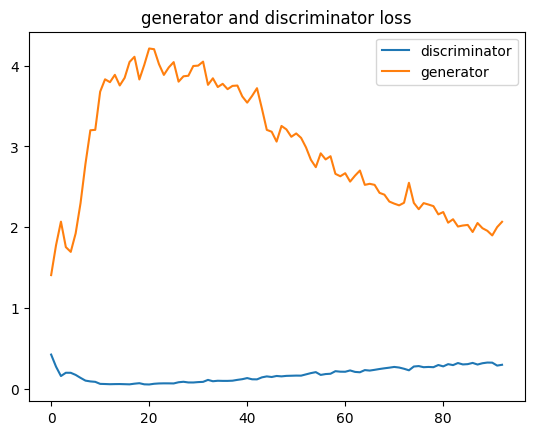

In [31]:
plt.plot(e,d_arr1)

# plt.title("discriminator loss")


plt.plot(e,g_arr1)

plt.title("generator and discriminator loss")
plt.legend(["discriminator", "generator"])

plt.show()


In [32]:
#Exp 2

# criterion = nn.BCEWithLogitsLoss()
# n_epochs = 100
# z_dim = 70
# display_step = 500
# batch_size = 128
# lr = 0.0001



In [33]:
g_arr2=[5.30275202822685, 5.160087472438812, 5.2134124569892855, 6.646924525260927, 5.845831020355221, 5.306099320411681, 5.7400821456909235, 5.3639566321373, 5.554935003757479, 4.938679921627047, 5.798419816970824, 5.686715950965884, 5.66690143203736, 5.1093106918335, 5.174841254711149, 5.0556553516387925, 5.441443700313572, 5.3266367034912125, 4.922633971214294, 5.097328124523165, 4.819585104465481, 4.757323320388789, 4.770360290527346, 4.995453658580782, 5.072837172985078, 4.729341459274297, 4.8658011837005555, 4.980373275756834, 4.512374598979952, 4.902640635967253, 4.840471796512605, 4.869800175666808, 4.33854002952576, 4.393869412899017, 4.516760442256928, 4.360543548583983, 4.3267823381423955, 4.402356220722201, 4.338554377555847, 4.452909986972814, 4.178497619628908, 4.241719212055208, 4.354785974502566, 3.8998442459106455, 3.9465472497940106, 4.162267340660094, 3.8037144150733906, 3.8773130865097047, 3.8945397853851302, 3.6558129706382734, 3.7531203503608745, 3.6238542814254764, 3.5061001873016355, 3.4802198419570907, 3.3353511710166908, 3.3597370166778564, 3.3825002875328094, 3.565993114471436, 3.4432068405151375, 3.4459355678558357, 3.36556086063385, 3.4472014608383157, 3.368738284587862, 3.3446545715332023, 3.2705915918350223, 3.2468129739761387, 3.320725681781771, 3.0176183996200594, 3.162250637054446, 3.126885901927947, 3.124146385669707, 3.1456081118583734, 3.181739449024204, 3.436795703411102, 3.321209989547729, 3.0739692468643187, 3.1833085141181923, 3.189580077171325, 3.0527778954505913, 3.3073316993713417, 3.194074320793151, 3.398983800888064, 3.268558537960055, 3.105949334144595, 3.024323796272278, 2.995270216464997, 2.9953858733177183, 3.08178401947022, 3.0597881841659538, 2.839214787006379, 2.9166552653312676, 2.9428323693275473, 3.0749437880516055]

In [34]:
d_arr2=[0.2066608522683378, 0.07797749568894506, 0.07491468643769625, 0.05343272836320105, 0.05902475792728367, 0.08605271327868111, 0.04471085842233148, 0.07672085023019468, 0.06044069585669784, 0.06768727197963745, 0.05651016927510492, 0.05103955667000258, 0.05430601033894353, 0.06332910227496177, 0.062247140701860215, 0.07137795964814718, 0.05178760816156861, 0.05638849598169326, 0.07353705395758149, 0.05959545263554905, 0.06743380764313044, 0.07530204720608889, 0.0707710408642888, 0.06473811832163483, 0.061761095424182705, 0.07076302662119269, 0.06906353857740763, 0.06890076282806691, 0.07828622103855006, 0.060025003118440584, 0.06556214352883402, 0.07923064208030703, 0.09238538795337085, 0.09384001176804303, 0.08084538964554676, 0.08867223936691879, 0.09104901660606268, 0.0894105959422886, 0.09134940729662777, 0.10092667540907856, 0.10086343850195405, 0.09670130392536522, 0.10071706908568742, 0.12100805897265685, 0.11153152293711913, 0.11956161905825154, 0.12036212944239377, 0.11990194863826033, 0.10950571932643653, 0.13486070936918246, 0.13127225567400447, 0.13422135598957552, 0.1436950219869612, 0.1454672462418674, 0.14888256537914266, 0.14120696423947798, 0.149324598327279, 0.13387434448301783, 0.14396986103057838, 0.1448053444772959, 0.1536289828717709, 0.1478323101103306, 0.15358125963807115, 0.15011701047420511, 0.16290431156754492, 0.1626361056566237, 0.1536417473703622, 0.18413544081151484, 0.1668967772275211, 0.1709227019399403, 0.16882521688938143, 0.17414116761088383, 0.15806665609776993, 0.14181388671696177, 0.16052827630192054, 0.1731409821063278, 0.16115214832127087, 0.16408422096073622, 0.1781757417619229, 0.15083402974903595, 0.16940237233042718, 0.14809995433688156, 0.16714669777452937, 0.17650583824515345, 0.17211684301495536, 0.18240438522398456, 0.18481532412767424, 0.17584100103378292, 0.17485196487605573, 0.20254525130987158, 0.18846488261222832, 0.18391173049807547, 0.176667158767581]

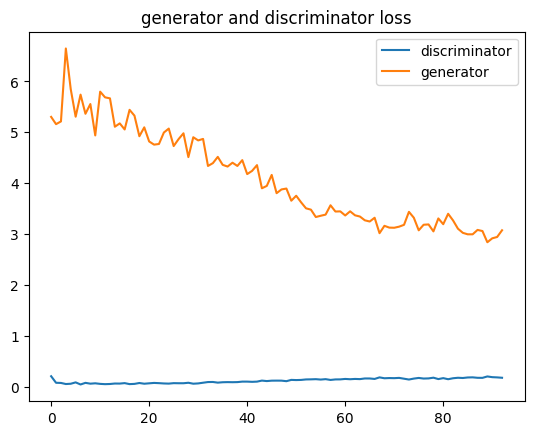

In [35]:
plt.plot(e,d_arr2)

# plt.title("discriminator loss")


plt.plot(e,g_arr2)

plt.title("generator and discriminator loss")
plt.legend(["discriminator", "generator"])

plt.show()

In [36]:
# criterion = nn.BCEWithLogitsLoss()
# n_epochs = 100
# z_dim = 50
# display_step = 500
# batch_size = 128
# lr = 0.0001

In [37]:
g_arr3=[4.938411118507382, 4.875740360736844, 5.184507826328272, 5.566122427463535, 5.147717844963082, 5.238047818660737, 4.829259389877321, 4.891333063602447, 5.172851923465724, 5.1627314214706415, 4.91822870540619, 5.0607471427917465, 4.970990365028381, 5.384164499282842, 5.015829594135285, 5.114162734985352, 5.29402313709259, 5.345512278556828, 4.9563098511695864, 5.092167475700376, 5.195940138816837, 4.847587614536286, 5.321360753059394, 5.00700522899628, 4.893767357349396, 4.874224353790285, 4.803076407432559, 4.437932158946993, 5.121705917358403, 4.940775127887724, 5.105298349380495, 5.15123809766769, 4.735944855690002, 4.949104124069212, 4.787909599304203, 5.011143177986146, 4.9421236443519545, 4.7741333823204055, 4.868509934902197, 4.908657626628876, 5.289897486209869, 5.260475191116327, 5.0873275918960585, 4.796180683612826, 4.7335308122634885, 4.640991778850558, 4.230175396442411, 4.414043511867527, 4.389739992141722, 4.206427602767945, 3.8919779119491547, 4.448360782623293, 4.200119043350217, 4.157496674537661, 4.089266776561737, 3.8755286607742274, 4.099977193832401, 3.9242670464515648, 3.7348988003730756, 3.777088851451871, 3.6173998913764933, 3.40649754047394, 3.6211690073013294, 3.443789977073671, 3.313385222911835, 3.4274258141517646, 3.434169573307036, 3.5336417160034195, 3.3796657810211155, 3.385331517219541, 3.1870378470420855, 3.485889087200164, 3.6750704002380323, 3.65338230895996, 3.4375898880958533, 3.3701263809204085, 3.4417958726882887, 3.4244556016922005, 3.3430534315109237, 3.339750843524936, 3.217087198257445, 3.2336094598770146, 3.304289105415344, 3.3024513750076303, 3.244303959369659, 3.3050707111358655, 3.2293182454109184, 3.4020278711319, 3.4456037783622744, 3.2015121974945107, 3.3277977781295798, 3.1695682091712967, 3.138735526561738]

In [38]:
d_arr3=[0.1826689189635216, 0.07426809391751883, 0.0543668601512909, 0.08774314530007549, 0.09097173146344731, 0.07647547085396944, 0.07741307732276616, 0.0642611360177397, 0.06763360589556396, 0.059423155997879784, 0.0735984293073416, 0.059080518496222735, 0.05665554092824454, 0.04537998678162695, 0.05838149447645991, 0.05399831925146283, 0.04543114677350969, 0.054323694882914435, 0.055395881662145215, 0.055279103521257686, 0.05632733738049869, 0.06237956607341764, 0.05072193710878499, 0.0590414766725153, 0.06850095598492764, 0.055610151791945076, 0.0819006034415215, 0.08605641039274642, 0.058035903451032954, 0.06625965321995321, 0.05556231971178208, 0.058306151547469195, 0.06724291129689669, 0.063425550756976, 0.0651321364231408, 0.06680815611965955, 0.07027008413709697, 0.07210389745607966, 0.07287488883361219, 0.056394132873043394, 0.06278383295051745, 0.062326711196452354, 0.058429716443643004, 0.07314145817235107, 0.07273727796040477, 0.08373761108517652, 0.09514586130529647, 0.09679795653745536, 0.09502299886941908, 0.1019479382485151, 0.11735745649784797, 0.0941834719702601, 0.0985575249120594, 0.10322223731130364, 0.11788727231323708, 0.12586006981134404, 0.10974573025852442, 0.1185521338544786, 0.13472245878726252, 0.11959694381058217, 0.1384686314091086, 0.14460225449502465, 0.15262921218574052, 0.15656876595318325, 0.1531215471774339, 0.15380293092131622, 0.15485654340684404, 0.14698865361511723, 0.15847533516585802, 0.1622489705458283, 0.1698451628834009, 0.1537997281104327, 0.13750293734669683, 0.1397038867995142, 0.1555932738780975, 0.15516537100076677, 0.1552910928577184, 0.15557406757771977, 0.15695080453157423, 0.15788087260723108, 0.1730824063569308, 0.16960816794633854, 0.17288956968486324, 0.1605420309752225, 0.16538191103935249, 0.15982869850099096, 0.16124728360772136, 0.14434636995941413, 0.15387354996800415, 0.1704672842770814, 0.16628490675985821, 0.17006868712604026, 0.17338783738017097]

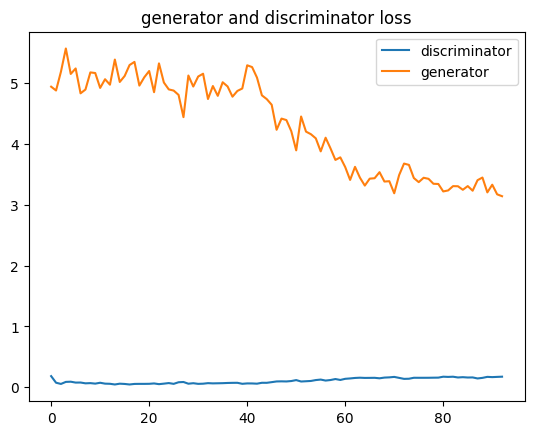

In [39]:
plt.plot(e,d_arr3)

# plt.title("discriminator loss")


plt.plot(e,g_arr3)

plt.title("generator and discriminator loss")
plt.legend(["discriminator", "generator"])

plt.show()